In [1]:
!pip install yfinance

In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Download Bitcoin price data
training_data = yf.download("BTC-USD", start="2019-01-01", end="2024-01-01")
testing_data = yf.download("BTC-USD", start="2024-01-01")

# Print confirmation messages
print("Training data downloaded and prepared!")
print("Testing data downloaded and prepared!")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Training data downloaded and prepared!
Testing data downloaded and prepared!


In [4]:
training_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824


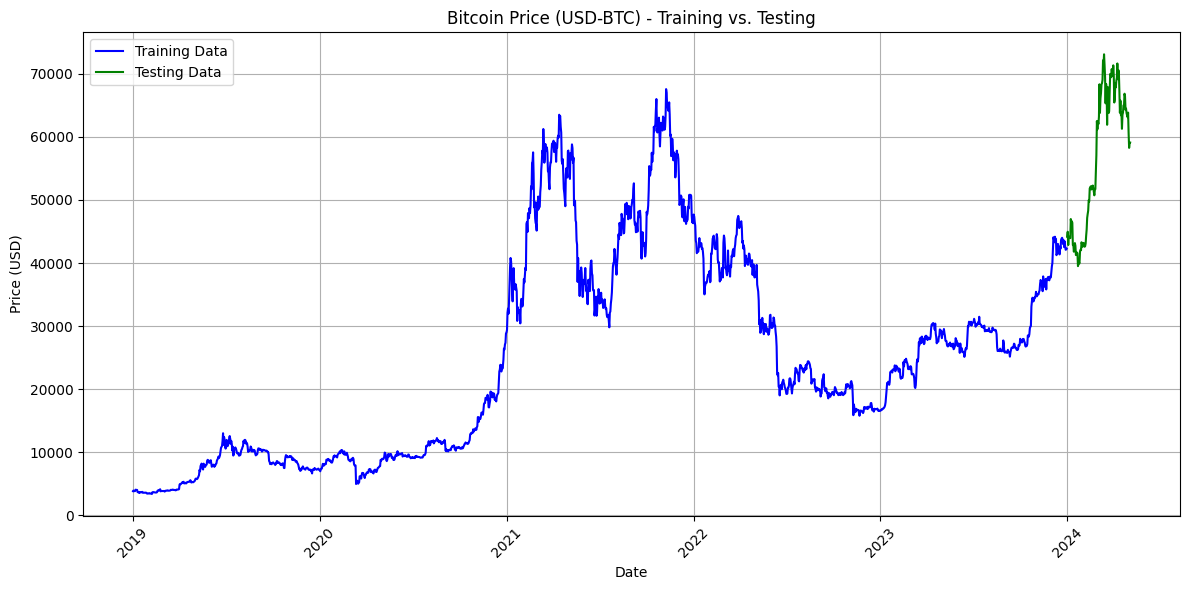

In [5]:
# Replace the above lines with your downloaded data (assuming 'Close' is the price column)
training_data_close = training_data['Close']  # Assuming 'Close' is the price column
testing_data_close = testing_data['Close']

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Plot training data in blue
plt.plot(training_data.index, training_data_close, color='blue', label='Training Data')

# Plot testing data in green
plt.plot(testing_data.index, testing_data_close, color='green', label='Testing Data')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price (USD-BTC) - Training vs. Testing')

# Rotate x-axis labels for better readability with many dates
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Create the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize to 0-1 range

# Normalize training data
scaled_training_data = scaler.fit_transform(training_data_close.values.reshape(-1, 1))

# Apply the same normalization to testing data (using the parameters from training)
scaled_testing_data = scaler.transform(testing_data_close.values.reshape(-1, 1))

In [7]:
# Define lookback window (number of past data points for prediction)
lookback_window = 60

# Prepare training data (X_train and y_train)
X_train = []
y_train = []
for i in range(lookback_window, len(scaled_training_data)):
  X_train.append(scaled_training_data[i-lookback_window:i, 0])  # Features (past data)
  y_train.append(scaled_training_data[i, 0])  # Target (data to predict)

X_train = np.array(X_train)  # Convert to NumPy array for efficiency
y_train = np.array(y_train)

In [8]:
# Define lookback window (number of past data points for prediction)
lookback_window = 60

# Prepare training data (X_train and y_train)
X_test = []
y_test = []
for i in range(lookback_window, len(scaled_testing_data)):
  X_test.append(scaled_testing_data[i-lookback_window:i, 0])  # Features (past data)
  y_test.append(scaled_testing_data[i, 0])  # Target (data to predict)

X_test = np.array(X_test)  # Convert to NumPy array for efficiency
y_test = np.array(y_test)

In [9]:
print(X_train.shape)
print(y_train.shape)

(1766, 60)
(1766,)


In [10]:
X_train = np.expand_dims(X_train, axis=-1)

In [11]:
X_test = np.expand_dims(X_test, axis=-1)

In [12]:
print(X_train.shape)
print(y_train.shape)

(1766, 60, 1)
(1766,)


In [13]:
class BitcoinPricePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout_prob=0.2):
        super(BitcoinPricePredictionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last time step's output for prediction
        return out


In [14]:
# Define model hyperparameters
lookback_window = 60
input_size = 1  # Since we're using normalized price as a single feature
hidden_size = 50
num_lstm_layers = 4
learning_rate = 0.01

# Convert data to tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create training and testing datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create the model
model = BitcoinPricePredictionModel(input_size, hidden_size, num_lstm_layers)

# Define loss function and optimizer
loss_function = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
  tot_loss = 0
  for data, target in train_loader:
    target = target.reshape(-1,1)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_function(output, target)
    tot_loss += loss.item()
    loss.backward()
    optimizer.step()
  tot_loss /= len(train_loader)

  # Optionally print training loss for monitoring
  if (epoch + 1) % 10 == 0:  # Print every 10 epochs
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {tot_loss:.4f}")

Epoch [10/100], Loss: 0.0009
Epoch [20/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0008
Epoch [40/100], Loss: 0.0007
Epoch [50/100], Loss: 0.0007
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0006
Epoch [100/100], Loss: 0.0005


In [15]:
preds = []
reals = []
model.eval()
for x_test, y_test in test_loader:
  y_pred = model(x_test)
  preds.append(y_pred)
  reals.append(y_test)
preds = torch.cat(preds)
reals = torch.cat(reals)
reals = reals.reshape(-1,1)
print(reals.shape)
preds.shape

torch.Size([64, 1])


torch.Size([64, 1])

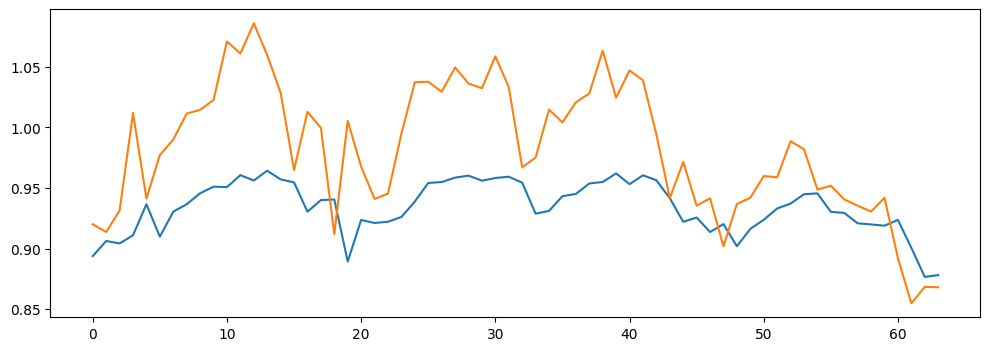

In [18]:
start = preds.shape[0]
plt.figure(figsize=(12,4))
plt.plot(range(start), preds.detach().numpy(), label='prediction')
plt.plot(range(start), reals.detach().numpy(), label='real')

In [20]:
torch.abs((preds - reals)).mean()

tensor(0.0529, grad_fn=<MeanBackward0>)